In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

events = pd.read_csv('events_month.csv')

In [14]:
#convert utc timestamp to local time
events['timestamp'] = pd.to_datetime(events['timestamp'])
events['pst'] = events['timestamp'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

#add hour column
events['hour'] = events['pst'].dt.strftime('%-H').astype(int)
#add weekday column
events['weekday'] = events['pst'].dt.strftime('%w').astype(int) 
events.head()

,bearing,delay,timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,signMessageLong,tripID,vehicle_id,vehicle_location_longitude,vehicle_location_latitude,pst,hour,weekday
0,42,-138,2017-01-01 00:05:35,10572,23,10574,24,MAX Red Line to Airport,6997146,416,-122.563200,45.560901,2016-12-31 16:05:35-08:00,16,6
1,270,-107,2017-01-01 00:07:26,10574,24,10576,25,MAX Red Line to Airport,6997146,416,-122.561480,45.572588,2016-12-31 16:07:26-08:00,16,6
2,299,-138,2017-01-01 00:10:39,10576,25,10579,26,MAX Red Line to Airport,6997146,416,-122.571721,45.580453,2016-12-31 16:10:39-08:00,16,6
3,1,-136,2017-01-01 00:04:51,11616,22,10572,23,MAX Red Line to Airport,6997146,416,-122.567106,45.556137,2016-12-31 16:04:51-08:00,16,6
4,42,-138,2017-01-01 00:05:35,10572,23,10574,24,MAX Red Line to Airport,6997146,417,-122.563200,45.560901,2016-12-31 16:05:35-08:00,16,6


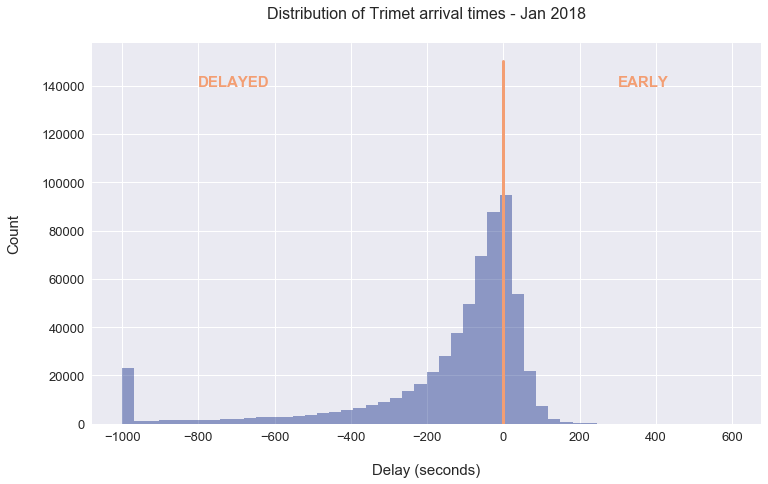

Most trains arrive on time or close to on time. More trains are delayed than early. Delay measurements cap out at -1000 seconds.


In [26]:
#plot distribution of arrival times
clean_events = events.loc[events.weekday.isin([0,1,2,3,4]) ] #select only weekday rides
clean_events = clean_events.dropna(subset=['delay'])
clean_events = clean_events['delay'].tolist()

sns.set_color_codes("dark")
sns.mpl.rc("figure", figsize=(12,7))
ax = sns.distplot(clean_events, kde=False, color = 'B' )
ax.set(xlabel='Delay (seconds)', ylabel='Count')


plt.rcParams["font.family"] = "sans-serif"
title = plt.title("Distribution of Trimet arrival times - Jan 2018", fontsize=16)
title.set_position([.5, 1.05])
plt.plot([0,0],[150000,0], linewidth=3, color="#f39e73")
plt.text(-800, 140000,'DELAYED', color="#f39e73", fontsize=15, weight="bold")
plt.text(300, 140000,'EARLY', color="#f39e73", fontsize=15, weight="bold")
plt.xlabel('Delay (seconds)', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()



print('Most trains arrive on time or close to on time. More trains are delayed than early. '  
      'Delay measurements cap out at -1000 seconds.')

ax.figure.savefig("images/dist_plot.png")

In [27]:
#analyze distribution
print("mean : ", np.mean(clean_events))
print("var  : ", np.var(clean_events))
print("skew: ",skew(clean_events)) #negative skew - long tail of delays
print("kurtosis: ",kurtosis(clean_events)) #positive kurtosis expected as trains typically arrive close to on time

mean :  -143.58567583
var  :  60780.8428402
skew:  -2.171010214322163
kurtosis:  4.3602272614505555


In [28]:
#grouping by hour and route name, calculate 
# 1. total delay count
# 2. delays normalized 
# 3. average delay time
# 4. average arrival time (average of both delays and early arrivals)

df = events[["hour","delay","signMessageLong"]]
df_delay = df.loc[df['delay'] < -60 ] #select only delays, excluding delays under 1 minute

df_total_delay = df_delay.groupby(["signMessageLong","hour"]).count().unstack()

count_events = df[['delay','signMessageLong','hour']].groupby(['signMessageLong','hour']).count()
count_delays = df_delay[['delay','signMessageLong','hour']].groupby(['signMessageLong','hour']).count()
df_normalized = pd.concat((count_delays,count_events),axis=1)
df_normalized.columns = ['total_delays','total_events']
df_normalized['percent'] = (df_normalized['total_delays']/df_normalized['total_events'])*100
#df_normalized = df_normalized.sort_values('percent')
df_normalized = df_normalized[['percent']].unstack()

df_avg_delay = df_delay.groupby(["signMessageLong","hour"]).mean().unstack()

df_avg_arrival = df.groupby(["signMessageLong","hour"]).mean().unstack()


It's immediately apparent that not all trains run at all hours of the day. The Blue Gresham/Hillsboro Lines have remarkably more delays compared to other lines. Delays tend to concentrate around the waking hours of 6:00 - 21:00, there are fewer delays in the early AM hours. Evening rush hour has an impact on delays, with delays picking up around 16:00.


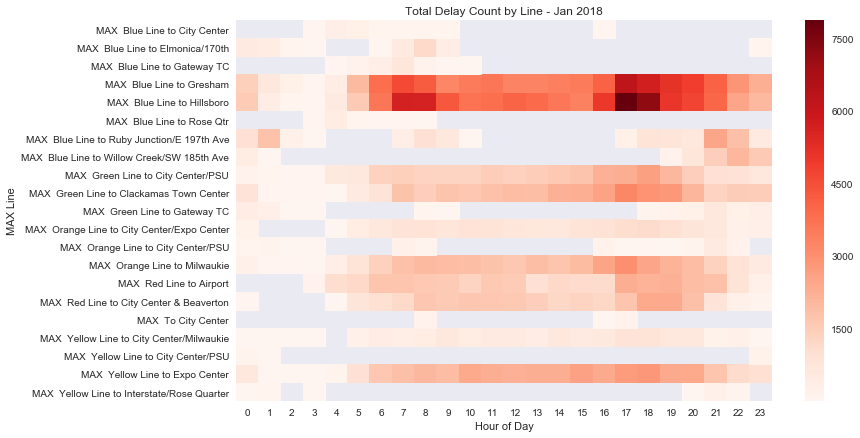

In [29]:
#heat map of total delay count by hour
mask = df_total_delay.isnull() #exclude nulls
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(df_total_delay, mask=mask, cmap="Reds", xticklabels=range(24))
ax.set(xlabel="Hour of Day", ylabel="MAX Line", title= "Total Delay Count by Line - Jan 2018")
ax.figure.savefig("images/count_hm.png",bbox_inches="tight")

print("It's immediately apparent that not all trains run at all hours of the day. " 
      "The Blue Gresham/Hillsboro Lines have remarkably more delays compared to other lines. "
      "Delays tend to concentrate around the waking hours of 6:00 - 21:00, there are "
      "fewer delays in the early AM hours. "
      "Evening rush hour has an impact on delays, with delays picking up around 16:00."
     )

After normalizing, the Blue Gresham/Hillsboro Lines no longer stand out as most delayed - they simply run at a greater frequency and thus has more total delays. Most lines show a greater percentage of delays during the evening hours, with delays visibly picking up around the 16:00 rush hour mark. Select lines such as MAX Yellow to Expo Center persistently run late throughout the day. The early AM hours and midday hours are least likely to be delayed.


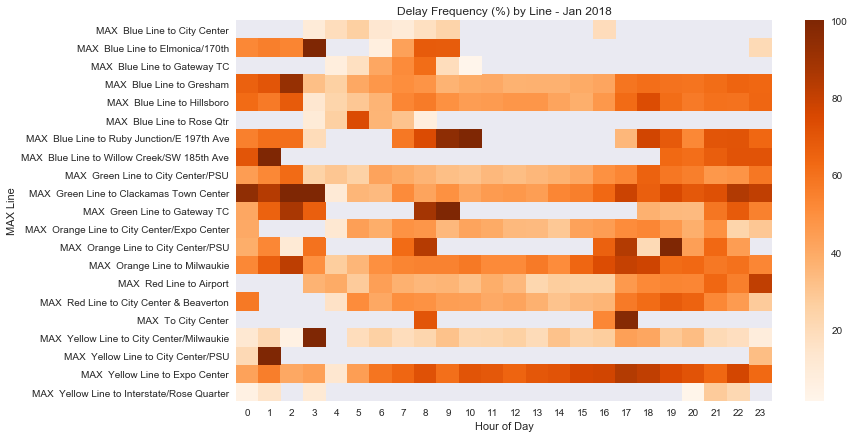

In [30]:
#heat map of total delay percentage by hour
mask = df_normalized.isnull() #exclude nulls
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
ax = sns.heatmap(df_normalized, mask=mask, cmap="Oranges", xticklabels=range(24))
ax.set(xlabel="Hour of Day", ylabel="MAX Line", title= "Delay Frequency (%) by Line - Jan 2018")

print("After normalizing, the Blue Gresham/Hillsboro Lines no longer stand out as most delayed - "
      "they simply run at a greater frequency and thus has more total delays. "
      "Most lines show a greater percentage of delays during the evening hours, "
      "with delays visibly picking up around the 16:00 rush hour mark. "
      "Select lines such as MAX Yellow to Expo Center persistently run late throughout the day. "
      "The early AM hours and midday hours are least likely to be delayed."
     )

ax.figure.savefig("images/norm_hm.png", bbox_inches="tight")

If delayed, the delays are usually not more than 200-400 seconds. This matches what we know from the distribution chart. Delays are longer in the evenings, with a spike during evening rush hour at 17:00. The delays continue into the night for select lines, such as the Max Blue Line to Hillsboro. Severe delays are unusual and may be caused by external factors such as power outage and/or malfunction.


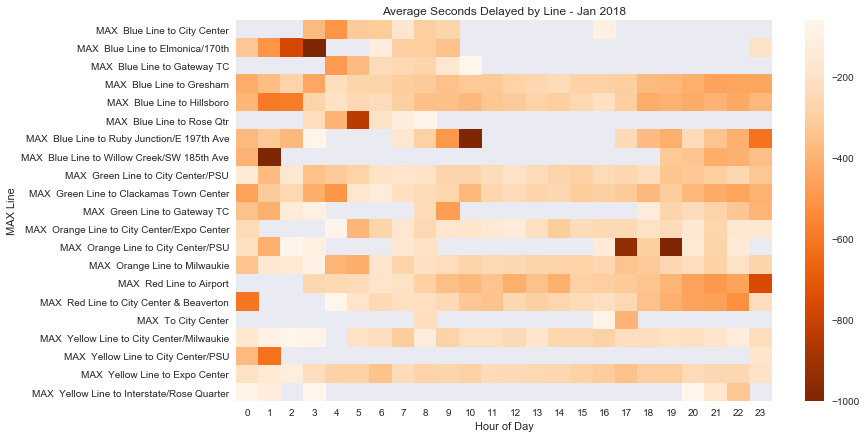

In [31]:
#heatmap of average delay by hour
mask = df_avg_delay.isnull() #exclude nulls
ax = sns.heatmap(df_avg_delay, mask=mask,cmap="Oranges_r", xticklabels=range(24))
ax.set(xlabel="Hour of Day", ylabel="MAX Line", title= "Average Seconds Delayed by Line - Jan 2018")

print("If delayed, the delays are usually not more than 200-400 seconds. "
      "This matches what we know from the distribution chart. "
      "Delays are longer in the evenings, with a spike during evening rush hour at 17:00. "
      "The delays continue into the night for select lines, such as the Max Blue Line to Hillsboro. "
      "Severe delays are unusual and may be caused by external factors such as power outage and/or malfunction."
     )

ax.figure.savefig("images/avgdelay_hm.png", bbox_inches="tight")

This chart includes early arrival data in the average. On average almost no trains arive earlier than scheduled, and most trains arrive close to on time with delays < 200 seconds. The early AM hours (4:00) show the most on-time arrivals and evening hours show greater delays.


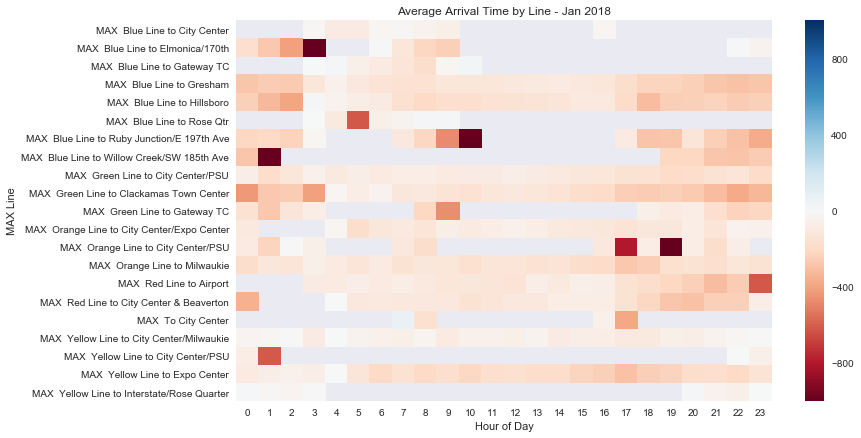

In [32]:
#heatmap of average arrival time by hour
mask = df_avg_arrival.isnull() #exclude nulls
ax = sns.heatmap(df_avg_arrival, mask=mask, cmap="RdBu", xticklabels=range(24))
ax.set(xlabel="Hour of Day", ylabel="MAX Line", title= "Average Arrival Time by Line - Jan 2018")

print("This chart includes early arrival data in the average. "
      "On average almost no trains arive earlier than scheduled, and most trains arrive "
      "close to on time with delays < 200 seconds. "
      "The early AM hours (4:00) show the most on-time arrivals and evening hours show greater delays."
     )

ax.figure.savefig("images/avgarrival_hm.png", bbox_inches="tight")